In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.metrics import classification_report
from datetime import datetime
from dask import dataframe


from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 1.1 Загрузка датасетов

In [2]:
train = pd.read_csv('data_train.csv', index_col='Unnamed: 0')
test = pd.read_csv('data_test.csv', index_col='Unnamed: 0')

##### Выгрузка необходимых данных из features.csv

In [3]:
# dask
feats = dataframe.read_csv('features.csv/features.csv', sep='\t')

# удаление колонки индекса
feats = feats.drop(columns='Unnamed: 0')
feats.head(1)

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


In [4]:
# преобразуем время в дату
train['buy_time'] = train.buy_time.apply(lambda x: datetime.fromtimestamp(x))
test['buy_time'] = test.buy_time.apply(lambda x: datetime.fromtimestamp(x))
feats['buy_time'] = feats.buy_time.apply(lambda x: datetime.fromtimestamp(x))

In [5]:
%%time
df = feats.merge(train, on='id').compute()
df['diff_time'] = np.abs(df['buy_time_x'] - df['buy_time_y']) # разница времени покупки в трейне и features.csv
df.sort_values('diff_time', inplace=True) # сортировка по разнице временеи данных
df.drop_duplicates(['id', 'buy_time_y', 'target', 'vas_id'], inplace=True) # удаление дубликатов, больших по разнице во времени

Wall time: 3min 49s


In [6]:
# # удаление признаков времени
# df.drop(['buy_time_x', 'buy_time_y'], axis=1, inplace=True)
# print('Совпадение количества строк:', df.shape[0] == train.shape[0])

In [7]:
df.drop('buy_time_x', axis=1, inplace=True)
df.rename(columns={'buy_time_y': 'buy_time'}, inplace=True)
df['buy_time'] = df.buy_time.apply(lambda x: x.month)

In [8]:
# преобразование даты в числовое значение
df['diff_time'] = df.diff_time.apply(lambda x: x.days)

# # преобразование в бинарный признак
# df.loc[df['252'] > 1, '252'] = 1

In [9]:
df.head(1)

,id,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,vas_id,buy_time,target,diff_time
816,1400940,-96.799971,196.890888,-110.740786,144.283202,-116.158246,123.17821,-16.08618,328.133903,-6.78366,...,108.252276,-2.832889,-0.694428,10.824067,-0.45614,1.0,1.0,9,0.0,0


In [10]:
print(f'Количество пропусков в тренировочных данных: {df.isna().sum().sum()}')
print(f'Количество пропусков в тестовых данных: {test.isna().sum().sum()}')

Количество пропусков в тренировочных данных: 0
Количество пропусков в тестовых данных: 0


#### Распределение целевой переменной

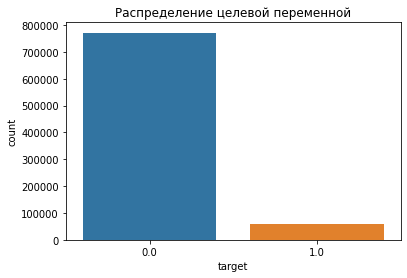

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

In [11]:
sns.countplot(data=train, x='target')
plt.title('Распределение целевой переменной')
plt.show()
train.target.value_counts() / train.target.shape

In [12]:
type(df)

pandas.core.frame.DataFrame

### 1.2 Разбиение тренировочных данных

In [13]:
# Разделим признаки и целевую переменную
data_prelim = df.copy()

data_prelim.set_index('id', inplace=True)

X = data_prelim.drop('target', axis=1)
y = data_prelim['target']

In [14]:
seed = 77

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=seed)


print("Train")
print(y_train.value_counts() / y_train.shape[0])
print()
print("Test")
print(y_test.value_counts() / y_test.shape[0])

Train
0.0    0.927632
1.0    0.072368
Name: target, dtype: float64

Test
0.0    0.927629
1.0    0.072371
Name: target, dtype: float64


### 1.3 Pipeline для baseline модели

In [15]:
# LogisticRegression

step_log_reg = ('log_reg', LogisticRegression(random_state=seed, n_jobs=-1))

In [16]:
bl_estimator = Pipeline([
    step_log_reg
])

### 1.4 Кросс-валидация

In [17]:
cv = KFold(n_splits=3, shuffle=True, random_state=seed)

def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.3f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [18]:
%time run_cv(bl_estimator, cv, X, y, model_name='BaseLine')

BaseLine: roc_auc = nan (+/- nan)
Wall time: 25.1 s


In [ ]:
bl_estimator.fit(X_train, y_train)
bl_y_pred = bl_estimator.predict_proba(X_test)[:, 1]

In [ ]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(bl_y_pred[~y_test.astype(bool)], bins=50, color='r', alpha=0.7);
plt.hist(bl_y_pred[y_test.astype(bool)], bins=50, color='b', alpha=0.7);

In [ ]:
print(classification_report(y_test, bl_y_pred > 0.5))

без предобработки признаков результат f1-score очень плохой результат без стандартизации

### 2 Типы признаков

In [15]:
X_nunique = X.apply(lambda x: x.nunique())
X_nunique.shape

(256,)

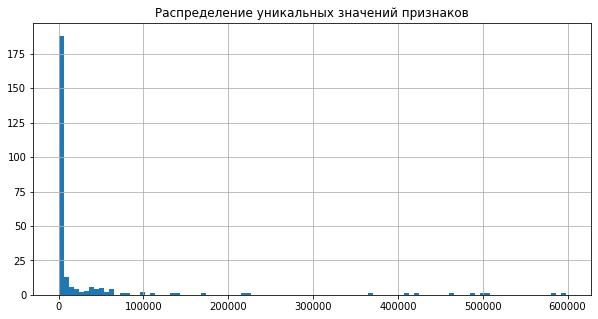

In [16]:
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=100, figsize=(10, 5));

In [17]:
f_all = set(X_nunique.index.tolist())
len(f_all)

256

#### константные признаки

In [18]:
# константные признаки
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

5

#### вещественные признаки

In [19]:
f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

247

In [20]:
f_other = f_all - (f_numeric | f_const) # остальные признаки
len(f_other)

4

#### бинарные признаки

In [21]:
f_binary = set(X.loc[:, f_other].columns[(
                      (X.loc[:, f_other].max() == 1) & \
                      (X.loc[:, f_other].min() == 0) & \
                      (X.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)

0

#### категориальные признаки

In [22]:
f_other = f_other - f_binary
len(f_other)

4

In [23]:
f_numeric.add('buy_time')
f_other.remove('buy_time')

In [24]:
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 31].index.tolist())
f_numeric_extra = f_categorical
len(f_categorical)

3

In [25]:
f_other = f_other - f_categorical
len(f_other)

0

In [26]:
f_other

set()

In [27]:
f_numeric.update(f_other)

In [28]:
assert(X_nunique.shape[0] == len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical))

In [29]:
print('f_all:', X.shape[1])
print()
print('f_const:', len(f_const))
print('f_binary:', len(f_binary))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))

f_ok = list(f_binary | f_categorical | f_numeric)
f_binary, f_categorical, f_numeric = list(f_binary), list(f_categorical), list(f_numeric)

f_all: 256

f_const: 5
f_binary: 0
f_categorical: 3
f_numeric: 248


### 3. Pipeline

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

#### Column Selector

In [31]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        
        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            print(KeyError("DataFrame не содержит колонки %s" % cols_error))

In [32]:
# проверка работы
cs_pipe = Pipeline([
    ('cs', ColumnSelector(columns=['1', '2', '15', '252'])),
])

In [33]:
cs_pipe.transform(X_test).head(2)

,1,2,15,252
id,,,,
4042440,-178.259112,-68.960786,-0.000725,0.0
2816536,104.530888,-110.740786,-0.000725,0.0


#### Prepare features

In [34]:
feat_prep_pipeline = make_pipeline(
    ColumnSelector(f_ok),
    FeatureUnion(transformer_list=[
        ('num_features', make_pipeline(
            ColumnSelector(f_numeric),
            StandardScaler()
        )),
        ('bin_features', make_pipeline(
            ColumnSelector(f_binary),
        )),
        ('cat_features', make_pipeline(
            ColumnSelector(f_categorical),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)

In [35]:
feat_prep_pipeline.steps

[('columnselector',
  ColumnSelector(columns=['124', '226', '11', '40', '224', '113', '43', '53',
                          '131', '223', '215', '161', '216', '130', '6', '103',
                          '127', '22', '92', '109', '79', '163', '246', '165',
                          '108', '119', '214', '89', '137', '251', ...])),
 ('featureunion',
  FeatureUnion(transformer_list=[('num_features',
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(columns=['124',
                                                                           '226',
                                                                           '11',
                                                                           '40',
                                                                           '224',
                                                                           '113',
                                         

In [36]:
X_test.shape[1]

256

In [44]:
feat_prep_pipeline.fit(X_train)

n_features = feat_prep_pipeline.transform(X_test).shape[1]
n_features

314

#### Gridsearch для пайплайнов

In [37]:
lg_pipe = make_pipeline(
    feat_prep_pipeline,
    LogisticRegression(random_state=seed)
)

In [38]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc', n_jobs=2):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)
    
    gsc.fit(X, y)
    
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    
    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

In [39]:
[k for k in lg_pipe.get_params().keys() if 'logisticregression' in k]

['logisticregression',
 'logisticregression__C',
 'logisticregression__class_weight',
 'logisticregression__dual',
 'logisticregression__fit_intercept',
 'logisticregression__intercept_scaling',
 'logisticregression__l1_ratio',
 'logisticregression__max_iter',
 'logisticregression__multi_class',
 'logisticregression__n_jobs',
 'logisticregression__penalty',
 'logisticregression__random_state',
 'logisticregression__solver',
 'logisticregression__tol',
 'logisticregression__verbose',
 'logisticregression__warm_start']

In [50]:
param_grid = {
    'logisticregression__penalty': ['l2', None],
    'logisticregression__C': [3, 1, 0.1, 0.01],
    'logisticregression__class_weight': [None, 'balanced']
}

In [47]:
KFold_cv = KFold(n_splits=3, shuffle=True, random_state=seed)

In [48]:
%%time
lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, cv=KFold_cv, n_jobs=2)

MemoryError: Unable to allocate 1.15 GiB for an array with shape (154687272,) and data type float64

вышеуказанные параметры не вносят существенных изменений в результат

#### Отбор признаков

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
feat_select = make_pipeline(
    feat_prep_pipeline,
    SelectFromModel(LogisticRegression(random_state=seed), threshold=10e-4)
)

In [ ]:
feat_prep_pipeline.fit(X_train, y_train)
feat_prep_pipeline.transform(X_test).shape

In [ ]:
feat_select.fit(X_train, y_train)
feat_select.transform(X_test).shape

In [ ]:
lg_feat_select_pipe = make_pipeline(
    feat_prep_pipeline,
    SelectFromModel(LogisticRegression(random_state=seed), threshold=1e-4),
    LogisticRegression(random_state=seed)
)

In [ ]:
[k for k in lg_feat_select_pipe.get_params() if 'select' in k]

In [ ]:
%%time
param_grid = [
    {
        "selectfrommodel__max_features": [None, 5, 10, 50, 100, 150],
        "selectfrommodel__threshold": [-np.inf]
    }
]

lg_feat_select_gsc = run_grid_search(lg_feat_select_pipe, X_train, y_train, param_grid, KFold_cv)

качество модели не меняется после от 50+ признаков

#### Лучшие параметры LogReg

In [263]:
lg_pipe_best = lg_feat_select_gsc.best_estimator_

In [264]:
%%time
lg_pipe_best.fit(X_train, y_train)

lg_pipe_best_pred = lg_pipe_best.predict_proba(X_test)[:,1]

Wall time: 52.3 s


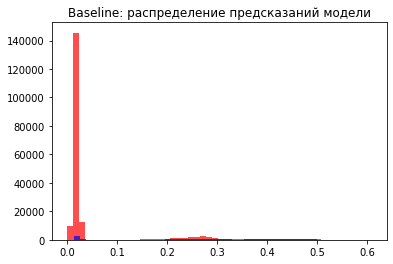

In [265]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(lg_pipe_best_pred[~y_test.astype(bool)], bins=50, color='r', alpha=0.7);
plt.hist(lg_pipe_best_pred[y_test.astype(bool)], bins=50, color='b', alpha=0.7);

In [271]:
print(classification_report(y_test, lg_pipe_best_pred > 0.3))

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95    192867
         1.0       0.41      0.44      0.42     15047

    accuracy                           0.91    207914
   macro avg       0.68      0.70      0.69    207914
weighted avg       0.92      0.91      0.91    207914



### Classifier

In [272]:
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

In [273]:
lgbm_feat_select_pipe = make_pipeline(
    feat_prep_pipeline,
    SelectFromModel(LogisticRegression(random_state=seed), threshold=-np.inf, max_features=50),
    LGBMClassifier(random_state=seed)
)

In [274]:
[k for k in lgbm_feat_select_pipe.get_params() if 'lgbm' in k]

['lgbmclassifier',
 'lgbmclassifier__boosting_type',
 'lgbmclassifier__class_weight',
 'lgbmclassifier__colsample_bytree',
 'lgbmclassifier__importance_type',
 'lgbmclassifier__learning_rate',
 'lgbmclassifier__max_depth',
 'lgbmclassifier__min_child_samples',
 'lgbmclassifier__min_child_weight',
 'lgbmclassifier__min_split_gain',
 'lgbmclassifier__n_estimators',
 'lgbmclassifier__n_jobs',
 'lgbmclassifier__num_leaves',
 'lgbmclassifier__objective',
 'lgbmclassifier__random_state',
 'lgbmclassifier__reg_alpha',
 'lgbmclassifier__reg_lambda',
 'lgbmclassifier__silent',
 'lgbmclassifier__subsample',
 'lgbmclassifier__subsample_for_bin',
 'lgbmclassifier__subsample_freq']

In [275]:
params = {
    'lgbmclassifier__boosting_type': [
                                      'gbdt',
                                      'dart', 
                                      'goss'
                                     ],
#     'lgbmclassifier__max_depth': [2, 4],
#     'lgbmclassifier__reg_alpha': [],
#     'lgbmclassifier__reg_lambda': [1, 3, 0.01, 0.1, 0.5],
#     'lgbmclassifier__learning_rate': [0.5, 0.1, 0.01, 0.05, 0.001],
#     'lgbmclassifier__n_estimators': [100, 200, 300],
    'lgbmclassifier__class_weight': ['balanced', None],
#     'lgbmclassifier__num_leaves': [],
    
}

In [276]:
%%time
lgbm_feat_select_gsc = run_grid_search(lgbm_feat_select_pipe, X_train, y_train, params, KFold_cv)

Best roc_auc score: 0.86

Best parameters set found on development set:

{'lgbmclassifier__boosting_type': 'dart', 'lgbmclassifier__class_weight': None}

Grid scores on development set:

0.860 (+/-0.003) for {'lgbmclassifier__boosting_type': 'gbdt', 'lgbmclassifier__class_weight': 'balanced'}
0.860 (+/-0.003) for {'lgbmclassifier__boosting_type': 'gbdt', 'lgbmclassifier__class_weight': None}
0.860 (+/-0.003) for {'lgbmclassifier__boosting_type': 'dart', 'lgbmclassifier__class_weight': 'balanced'}
0.861 (+/-0.003) for {'lgbmclassifier__boosting_type': 'dart', 'lgbmclassifier__class_weight': None}
0.860 (+/-0.003) for {'lgbmclassifier__boosting_type': 'goss', 'lgbmclassifier__class_weight': 'balanced'}
0.860 (+/-0.003) for {'lgbmclassifier__boosting_type': 'goss', 'lgbmclassifier__class_weight': None}

Wall time: 6min 19s


In [277]:
lgbm_pipe_best = lgbm_feat_select_gsc.best_estimator_

In [278]:
%%time
lgbm_pipe_best.fit(X_train, y_train)

lgbm_pipe_best_pred = lgbm_pipe_best.predict_proba(X_test)[:,1]

Wall time: 44.2 s


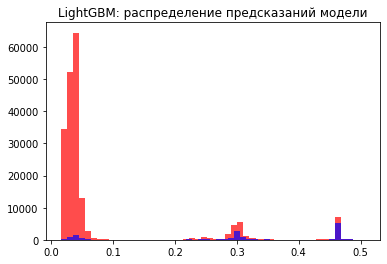

In [279]:
plt.title("LightGBM: распределение предсказаний модели")
plt.hist(lgbm_pipe_best_pred[~y_test.astype(bool)], bins=50, color='r', alpha=0.7);
plt.hist(lgbm_pipe_best_pred[y_test.astype(bool)], bins=50, color='b', alpha=0.7);

In [284]:
print(classification_report(y_test, lgbm_pipe_best_pred > 0.1))

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    192867
         1.0       0.32      0.79      0.45     15047

    accuracy                           0.86    207914
   macro avg       0.65      0.83      0.69    207914
weighted avg       0.93      0.86      0.89    207914

